## Imports & Utils


In [ ]:
%%capture
!pip install datasets
# !pip install torch-lr-finder

In [ ]:
%load_ext tensorboard

In [ ]:
%%capture
from datetime import datetime
from datasets import load_dataset
from huggingface_hub import hf_hub_download
import pandas as pd
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torch.nn as nn
import copy
import torch.optim as optim
from torch.optim import AdamW
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report
import os
from google.colab import drive
# from torch_lr_finder import LRFinder
from torch.utils.tensorboard import SummaryWriter


In [ ]:
drive.mount('/content/drive')
save_path = "/content/drive/My Drive/ML_Models"
log_dir = "/content/drive/My Drive/TensorBoardLogs"
os.makedirs(save_path, exist_ok=True)

Mounted at /content/drive


In [ ]:
def preprocess(batch, label_dict, class_map_inv, rare_classes, train_transforms, val_transforms, strong_transforms, is_train=True):

    images, labels = [], []

    for img, key in zip(batch["jpg"], batch["__key__"]):
        label = label_dict[key]

        if is_train:
            transform = train_transforms if class_map_inv[label] not in rare_classes else strong_transforms
        else:
            transform = val_transforms

        img = transform(img)
        images.append(img)
        labels.append(torch.tensor(label, dtype=torch.long))

    return {"img": images, "label": labels}

# Function to denormalize the image
def denormalize(image):

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std + mean

    return np.clip(image, 0, 1)


# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early stopping triggered after {self.counter} epochs of no improvement.")
                return True
        return False

def save_model(model, save_path, model_name):

    model_filename = f"{model_name}.pt"
    torch.save(model.state_dict(), f"{save_path}/{model_filename}")
    print(f"Model saved to {save_path}/{model_filename}")

def update_scheduler(scheduler, val_loss):
    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(val_loss)
    else:
        scheduler.step()

def evaluation_report(model, dl_val, class_map_inv, device):
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(dl_val, desc="Evaluating"):
            images = batch["img"].to(device)
            labels = batch["label"].to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    y_pred = [class_map_inv[x] for x in all_preds]
    y_true = [class_map_inv[x] for x in all_labels]

    print(classification_report(y_true, y_pred, zero_division=0))

## Load, Transform & Preprocess a dataset



In [ ]:
%%capture
t = datetime.now()
ds = load_dataset("mikkoim/aquamonitor-jyu", cache_dir="data")
hf_hub_download(repo_id="mikkoim/aquamonitor-jyu", filename="aquamonitor-jyu.parquet.gzip", repo_type="dataset", local_dir=".")
metadata = pd.read_parquet('aquamonitor-jyu.parquet.gzip')
classes = sorted(metadata["taxon_group"].unique())
class_map = {k:v for v,k in enumerate(classes)}
class_map_inv = {v:k for k,v in class_map.items()}
metadata["img"] = metadata["img"].str.removesuffix(".jpg")
label_dict = dict(zip(metadata["img"], metadata["taxon_group"].map(class_map)))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.73k [00:00<?, ?B/s]

train.tar:   0%|          | 0.00/143M [00:00<?, ?B/s]

val.tar:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/40880 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6394 [00:00<?, ? examples/s]

aquamonitor-jyu.parquet.gzip:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

In [ ]:
# Count the number of images in each class
class_distribution = metadata["taxon_group"].value_counts()
print(class_distribution)

taxon_group
Oulimnius tuberculatus          3744
Leptophlebia                    3443
Chironomidae                    3304
Caenis horaria                  2955
Kageronia fuscogrisea           2876
Asellus aquaticus               2633
Oligochaeta                     2613
Micronecta                      1800
Caenis luctuosa                 1760
Tinodes waeneri                 1757
Ceratopogonidae                 1458
Stylaria lacustris              1440
Hydroptila                      1335
Mystacides azurea               1199
Heptagenia dalecarlica          1168
Limnephilus                     1156
Ephemera vulgata                1137
Spirosperma ferox               1126
Tanypodinae                     1106
Hydrachnidia                    1101
Limnephilidae                   1039
Oulimnius tuberculatus adult    1006
Helobdella stagnalis             988
Erpobdella octoculata            888
Psychomyia pusilla               760
Cloeon dipterum                  748
Cyrnus flavidus           

In [ ]:
# @title Transform and preprocess datasets
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomApply([transforms.RandomAffine(
        degrees=10,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05))], p=0.3),

    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.1, p=0.5)], p=0.3),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5))], p=0.2),

    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

strong_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomApply([transforms.RandomAffine(
        degrees=15,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=5)], p=0.5),

    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2, p=0.5)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.3),
    transforms.RandomApply([transforms.ElasticTransform(alpha=50.0)], p=0.3),
    transforms.RandomApply([transforms.RandomErasing(scale=(0.02, 0.1), ratio=(0.3, 3.3))], p=0.3),

    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Identify small classes (less than 2000 samples)
rare_classes = {label for label, count in metadata["taxon_group"].value_counts().items() if count < 2000}

image_to_class = dict(zip(metadata["img"], metadata["taxon_group"]))
weight_per_class = {class_name: 1.0 / count for class_name, count in class_distribution.items()}
sample_weights = [weight_per_class[image_to_class[sample["__key__"]]] for sample in ds["train"]]


sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)


ds_train = ds["train"].with_transform(
    lambda batch: preprocess(batch, label_dict, class_map_inv, rare_classes, train_transforms, val_transforms, strong_transforms, is_train=True)
)

ds_val = ds["validation"].with_transform(
    lambda batch: preprocess(batch, label_dict, class_map_inv, rare_classes, train_transforms, val_transforms, strong_transforms, is_train=False)
)

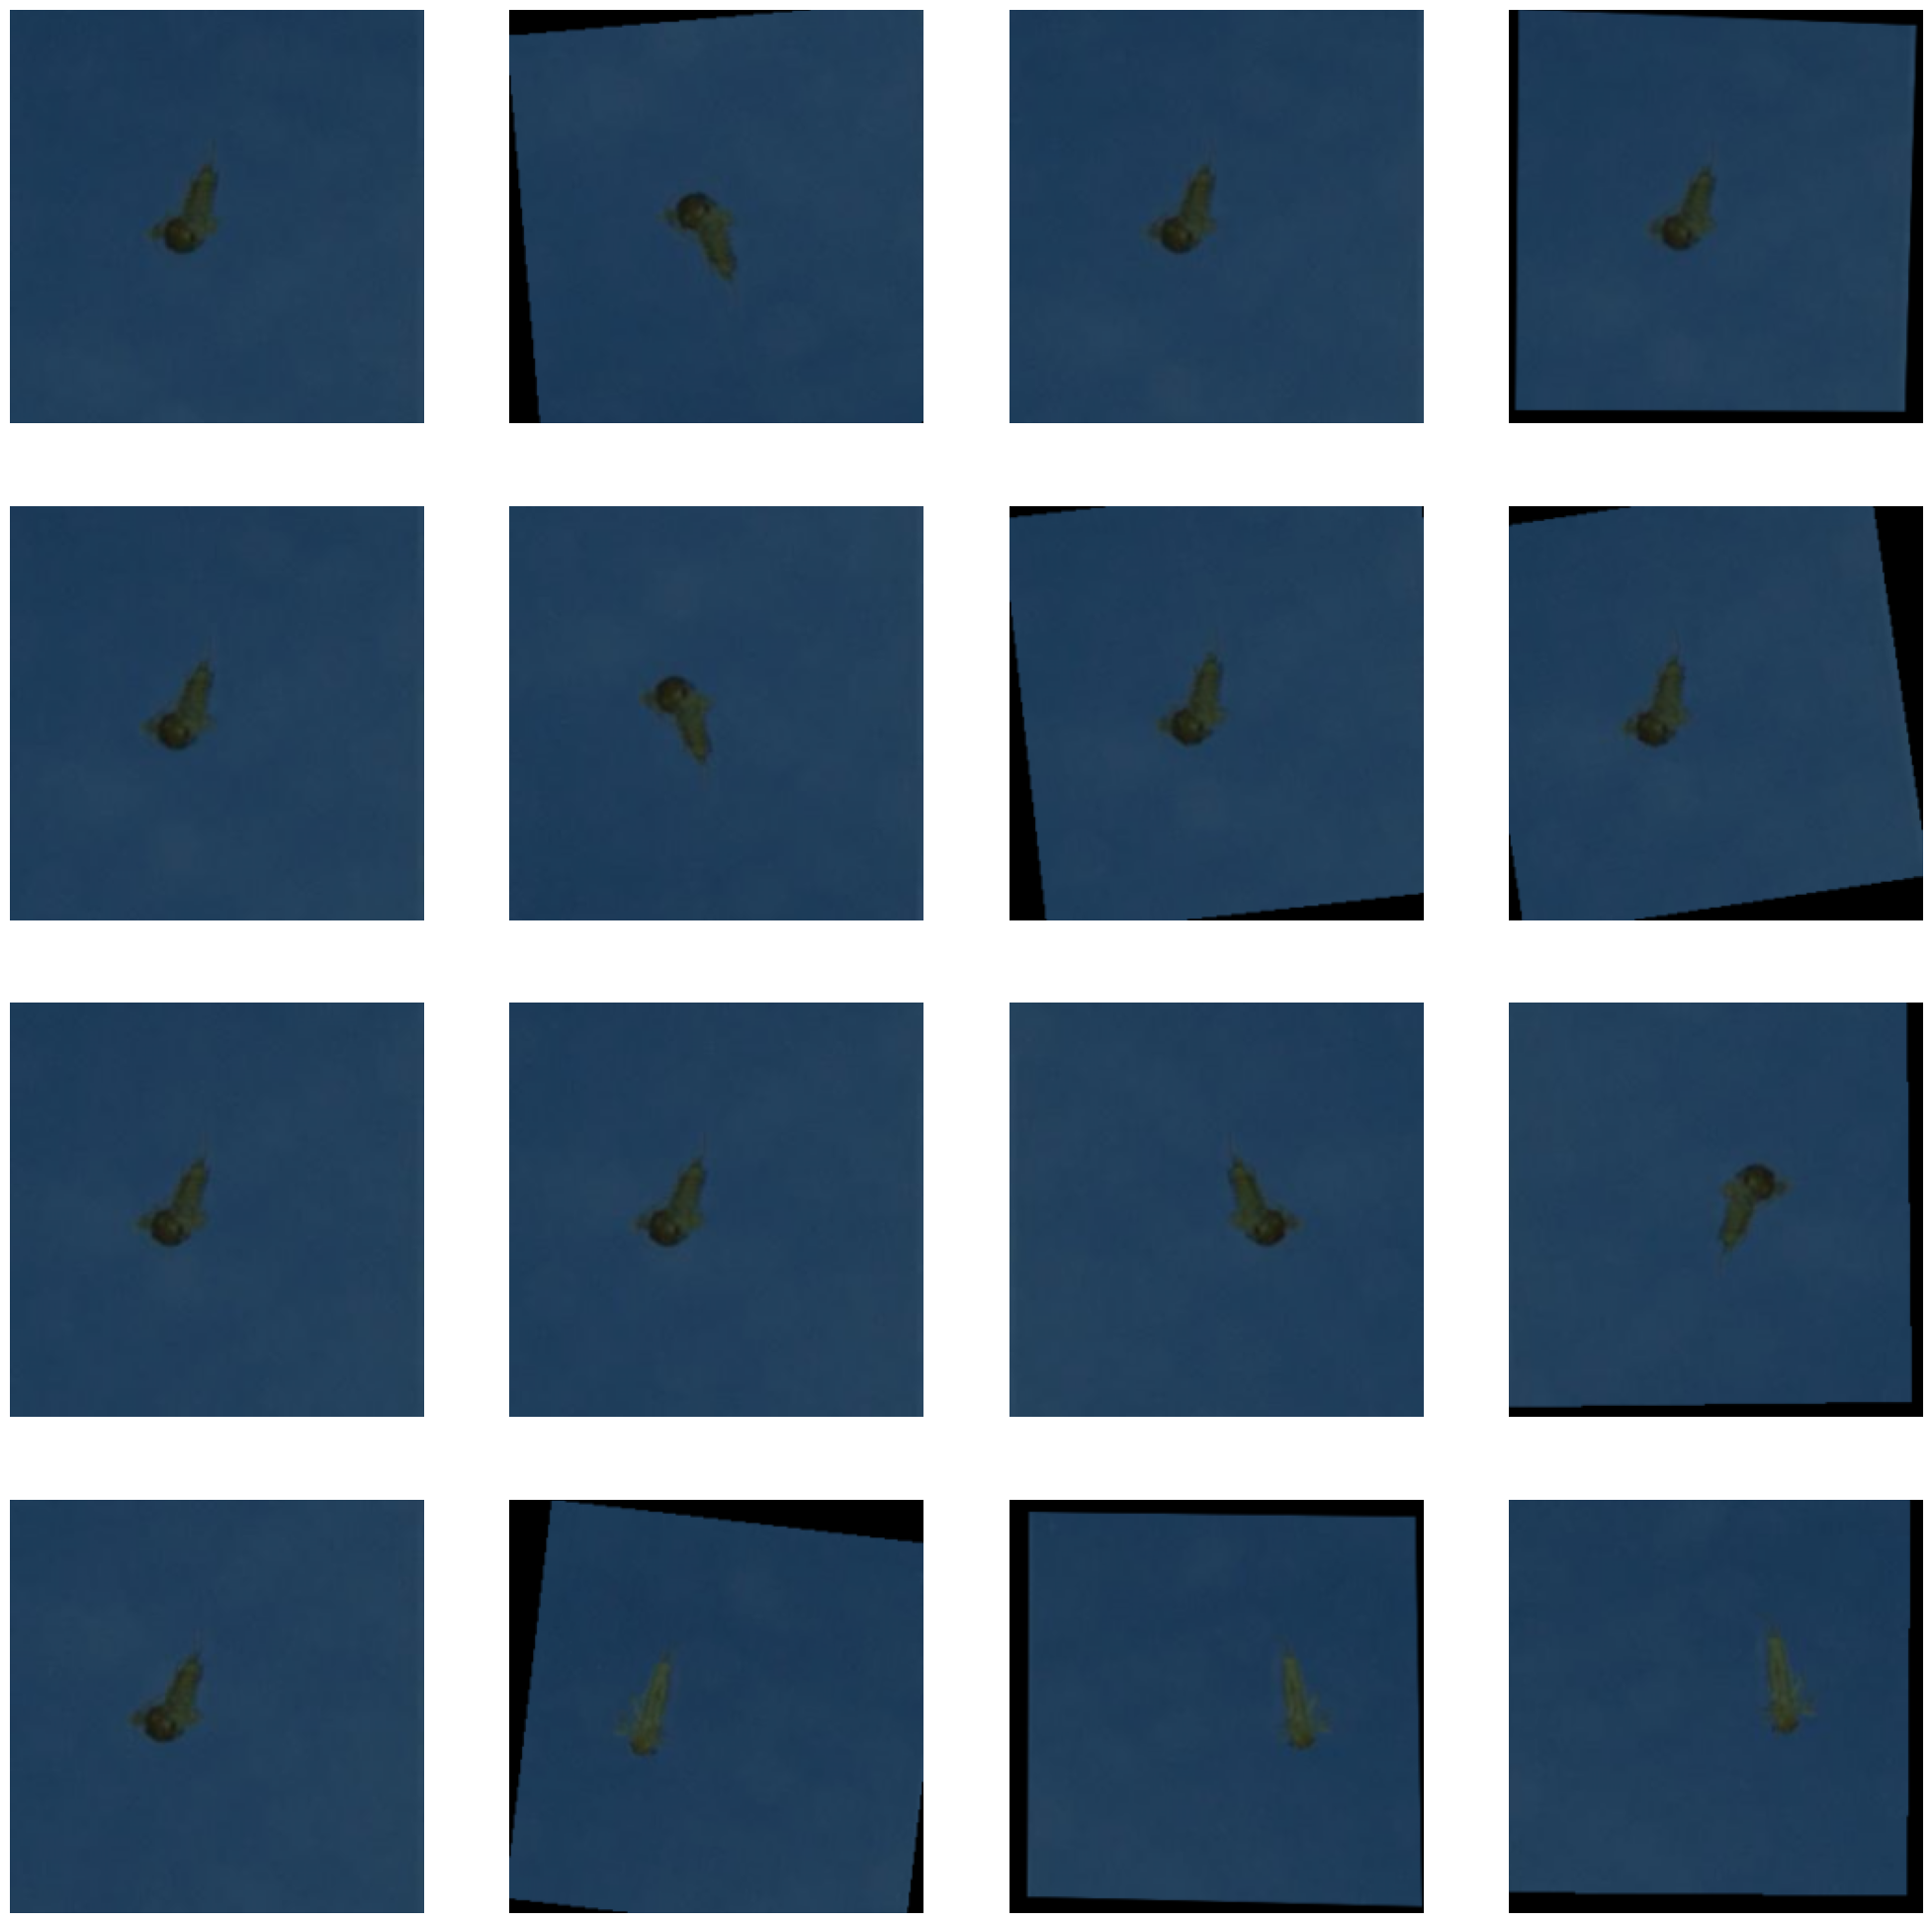

In [ ]:
# @title Check image augmentation

fig, axes = plt.subplots(4, 4, figsize=(25, 25))

for i, ax in enumerate(axes.flat):
    if i >= 20:
        break
    image, label = ds_train[i]["img"], ds_train[i]["label"]
    image = image.permute(1, 2, 0).numpy()  # Convert from tensor to numpy array
    image = denormalize(image)  # Denormalize the image
    ax.imshow(image)
    ax.axis('off')

## Model Training Functions

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import torch.utils.checkpoint as checkpoint


def train_one_epoch(model, optimizer, criterion, dl_train, device, scaler, writer=None, epoch=0, log_freq=50, global_step=0):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for i, batch in enumerate(dl_train):
        images, labels = batch["img"].to(device, non_blocking=True), batch["label"].to(device, non_blocking=True)
        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):

            outputs = model(images)

            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


        global_step += 1


        if writer and (i % log_freq == 0 or i == len(dl_train) - 1):
            current_lr = optimizer.param_groups[0]['lr']
            train_loss = running_loss / (i + 1)
            train_acc = correct / total

            writer.add_scalar('Train/Loss', train_loss, global_step)
            writer.add_scalar('Train/Accuracy', train_acc, global_step)
            writer.add_scalar('LearningRate', current_lr, global_step)

    train_loss = running_loss / len(dl_train)
    train_acc = correct / total
    return train_loss, train_acc, global_step

from sklearn.metrics import f1_score

def evaluate_model(model, criterion, dl_val, device, writer=None, global_step=0, log_freq=50):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for i, batch in enumerate(dl_val):
            images, labels = batch["img"].to(device, non_blocking=True), batch["label"].to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())


            if writer and (i % log_freq == 0 or i == len(dl_val) - 1):
                writer.add_scalar('Validation/Loss', val_loss / (i + 1), global_step + i)
                writer.add_scalar('Validation/Accuracy', 100 * correct / total, global_step + i)


    val_loss /= len(dl_val)
    val_acc = 100 * correct / total
    val_f1 = f1_score(all_labels, all_preds, average='macro')

    return val_loss, val_acc, val_f1


def train_model(model, optimizer, criterion, scaler, dl_train, dl_val, device, num_epochs=5,
                early_stopping=None, scheduler=None, use_scheduler=False,
                save_path=save_path, model_name="best_model", log_dir=None, log_freq=50):

    writer = SummaryWriter(log_dir=f"{log_dir}/{model_name}") if log_dir else None
    torch.backends.cudnn.benchmark = True


    best_val_f1 = -np.inf
    best_val_acc = -np.inf

    global_step = 0
    for epoch in range(num_epochs):
        train_loss, train_acc, global_step = train_one_epoch(model, optimizer, criterion, dl_train, device, scaler, writer, epoch, log_freq, global_step)
        val_loss, val_acc, val_f1 = evaluate_model(model, criterion, dl_val, device, writer, global_step, log_freq)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%")


        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            save_model(model, save_path, f"{model_name}_f1")
            print(f"Model saved based on best F1-score: {val_f1:.4f}")


        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_model(model, save_path, f"{model_name}_val_acc")
            print(f"Model saved based on best Accuracy: {val_acc:.2f}%")


        global_step += len(dl_train)


        if use_scheduler and scheduler is not None:
            scheduler.step()

            current_lr = scheduler.get_last_lr()
            print(f"Epoch {epoch+1}: Learning Rate: {current_lr}")


        if early_stopping and early_stopping(val_f1):
            print("Early stopping activated. Training stopped.")
            break

    if writer:
        writer.close()


In [ ]:
import itertools

def update_dropout_in_module(module, dropout_p):
    for child_name, child in module.named_children():

        if isinstance(child, nn.Dropout):

            if any(p.requires_grad for p in module.parameters()):
                child.p = dropout_p
        else:

            if any(p.requires_grad for p in child.parameters()):
                update_dropout_in_module(child, dropout_p)
            else:

                update_dropout_in_module(child, dropout_p)



def grid_search_hyperparams(model,
    train_loader, val_loader,
    dropout_list, label_smoothing_list, weight_decay_list,
    lr_value,
    epochs=5,
    device='cuda',
    update_dropout=True
):
    best_val_acc = 0.0
    best_params = None
    results = {}

    torch.backends.cudnn.benchmark = True
    scaler = torch.amp.GradScaler()
    best_val_loss = np.inf

    for dropout, smoothing, wd in itertools.product(dropout_list, label_smoothing_list, weight_decay_list):
        mdl = copy.deepcopy(model).to(device)


        if update_dropout:
            update_dropout_in_module(mdl, dropout)

        criterion = nn.CrossEntropyLoss(label_smoothing=smoothing)

        optimizer = optim.AdamW([p for p in mdl.parameters() if p.requires_grad],
                                  lr=lr_value, weight_decay=wd)

        for ep in range(epochs):
            train_loss, train_acc, _ = train_one_epoch(mdl, optimizer, criterion, train_loader, device, scaler)
            val_loss, val_acc = evaluate_model(mdl, criterion, val_loader, device)

            print(f"[dropout={dropout}, smoothing={smoothing}, wd={wd}] "
                  f"Epoch {ep+1}/{epochs} | Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        results[(dropout, smoothing, wd)] = val_acc

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = (dropout, smoothing, wd)

    return best_params, best_val_acc, results

## Loading the model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights_tiny = models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1
model = models.convnext_tiny(weights=weights_tiny)


for stage in model.features:
    if isinstance(stage, nn.Sequential):
        for block in stage:
            if hasattr(block, 'stochastic_depth'):
                block.stochastic_depth.p = 0.0

model.to(device)


## Model training

In [ ]:
batch_size = 512

dl_train = DataLoader(ds_train, batch_size=batch_size, sampler=sampler,
                      num_workers=8, pin_memory=True, persistent_workers=True,
                      drop_last=False)

dl_val = DataLoader(ds_val, batch_size=batch_size,
                      num_workers=8, pin_memory=True, persistent_workers=True,
                      drop_last=False)

### Unfreezing the model

In [ ]:
num_classes = len(classes)
in_features = model.classifier[-1].in_features

in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features, num_classes).to(device)


nn.init.normal_(model.classifier[-1].weight, mean=0.0, std=0.001)
nn.init.zeros_(model.classifier[-1].bias)


for param in model.parameters():
    param.requires_grad = True

In [ ]:
scaler = torch.cuda.amp.GradScaler()

base_lr = 5e-5
decay_factor = 0.8


param_groups = [
    {"params": list(model.features[0].parameters()), "lr": base_lr * decay_factor ** 6},
    {"params": list(model.features[1].parameters()) + list(model.features[2].parameters()), "lr": base_lr * decay_factor ** 5},
    {"params": list(model.features[3].parameters()) + list(model.features[4].parameters()), "lr": base_lr * decay_factor ** 4},
    {"params": list(model.features[5][0:3].parameters()), "lr": base_lr * decay_factor ** 3},
    {"params": list(model.features[5][3:6].parameters()), "lr": base_lr * decay_factor ** 2},
    {"params": list(model.features[5][6:9].parameters()) + list(model.features[6].parameters()), "lr": base_lr * decay_factor ** 1},
    {"params": list(model.features[7].parameters()), "lr": base_lr},
    {"params": list(model.classifier.parameters()), "lr": base_lr},
]


optimizer = torch.optim.AdamW(param_groups, weight_decay=1e-8)


min_lr = base_lr * decay_factor ** 6


scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=min_lr)

<ipython-input-16-1e796bded83f>:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


train_model(model, optimizer, criterion, scaler, dl_train, dl_val, device, num_epochs=30,
            early_stopping=None, scheduler=scheduler, use_scheduler=True,
            save_path=save_path, model_name="best_model",
            log_dir=None, log_freq=0)

Epoch [1/30], Train Loss: 2.8736, Train Acc: 0.5027
Validation Loss: 2.2310, Validation Acc: 62.07%
Model saved to /content/drive/My Drive/ML_Models/best_model_f1.pt
Model saved based on best F1-score: 0.5555
Model saved to /content/drive/My Drive/ML_Models/best_model_val_acc.pt
Model saved based on best Accuracy: 62.07%
Epoch 1: Learning Rate: [1.3107200000000006e-05, 1.6375024673371383e-05, 2.0459805515085605e-05, 2.5565781567228386e-05, 3.194825163240686e-05, 3.992633921387995e-05, 4.989894869072132e-05, 4.989894869072132e-05]
Epoch [2/30], Train Loss: 1.6549, Train Acc: 0.7916
Validation Loss: 1.4207, Validation Acc: 75.49%
Model saved to /content/drive/My Drive/ML_Models/best_model_f1.pt
Model saved based on best F1-score: 0.7082
Model saved to /content/drive/My Drive/ML_Models/best_model_val_acc.pt
Model saved based on best Accuracy: 75.49%
Epoch 2: Learning Rate: [1.3107200000000006e-05, 1.6348197029042272e-05, 2.0399443315345102e-05, 2.5463501173223646e-05, 3.1793573495571824e-

In [ ]:
model.load_state_dict(torch.load("/content/drive/My Drive/ML_Models/best_model_f1.pt"))
model.to(device)

<ipython-input-19-28d9fe8ee1c9>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/My Drive/ML_Models/best_model_f1.pt"))


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [ ]:
evaluation_report(model, dl_val, class_map_inv, device)


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

                              precision    recall  f1-score   support

           Asellus aquaticus       0.92      0.96      0.94       474
              Caenis horaria       0.47      0.88      0.62       200
             Caenis luctuosa       0.82      0.46      0.59       280
             Ceratopogonidae       0.91      1.00      0.95       240
                Chironomidae       0.79      0.98      0.87       309
             Cloeon dipterum       0.93      0.84      0.88       158
             Cyrnus flavidus       0.60      1.00      0.75        80
            Ecnomus tenellus       0.00      0.00      0.00       120
            Ephemera vulgata       0.69      1.00      0.82        40
       Erpobdella octoculata       0.94      0.90      0.92       210
                    Gyraulus       1.00      1.00      1.00        15
        Helobdella stagnalis       0.69      0.82      0.75        65
      Heptagenia dalecarlica       1.00      0.88      0.94        76
                Hyd

In [ ]:
model.load_state_dict(torch.load("/content/drive/My Drive/ML_Models/best_model_val_acc.pt"))
model.to(device)

<ipython-input-21-108cd1a8d2a7>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/My Drive/ML_Models/best_model_val_acc.pt"))

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [ ]:
evaluation_report(model, dl_val, class_map_inv, device)

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

                              precision    recall  f1-score   support

           Asellus aquaticus       0.91      0.99      0.95       474
              Caenis horaria       0.57      0.93      0.71       200
             Caenis luctuosa       0.85      0.47      0.61       280
             Ceratopogonidae       0.89      1.00      0.94       240
                Chironomidae       0.81      0.97      0.89       309
             Cloeon dipterum       0.83      0.89      0.86       158
             Cyrnus flavidus       0.63      1.00      0.78        80
            Ecnomus tenellus       0.00      0.00      0.00       120
            Ephemera vulgata       0.63      1.00      0.78        40
       Erpobdella octoculata       0.94      0.90      0.92       210
                    Gyraulus       1.00      1.00      1.00        15
        Helobdella stagnalis       0.71      0.80      0.75        65
      Heptagenia dalecarlica       1.00      0.86      0.92        76
                Hyd

### Testing the model

In [ ]:
# model.py
import torch
import torch.nn as nn
import torchvision.models as models

class MyConvNeXtTiny(nn.Module):
    def __init__(self, num_classes=31):
        super().__init__()
        self.model = models.convnext_tiny(weights=None, out_features=num_classes)
    def forward(self, x):
        return self.model(x)

def create_model(num_classes=31):
    """Створює екземпляр моделі."""
    return MyConvNeXtTiny(num_classes=num_classes)


In [ ]:
model = MyConvNeXtTiny(num_classes=31)

state_dict = torch.load("/content/drive/My Drive/ML_Models/best_model_f1.pt", weights_only=True)
model.load_state_dict(state_dict, strict=True)

model.eval()

all_preds = []
all_labels = []


with torch.no_grad():
    for batch in dl_val:
        images = batch["img"]
        labels = batch["label"]


        outputs = model(images)


        preds = torch.argmax(outputs, dim=1)


        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


y_pred = [class_map_inv[x] for x in all_preds]
y_true = [class_map_inv[x] for x in all_labels]


print("Predictions:", y_pred[:10])
print("Ground Truth:", y_true[:10])



In [ ]:
evaluation_report(model, dl_val, class_map_inv, device)

## Model Validation

In [ ]:

%%capture
!pip install transformers datasets
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from datasets import load_dataset
from huggingface_hub import hf_hub_download
import pandas as pd
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
NUM_CLASSES = 31
IMAGE_SIZE = (224, 224)
MODEL_PATH = "/content/drive/My Drive/best_model_f1.pt"


class ConvNeXtTinyModel(nn.Module):
    def __init__(self, num_classes=31):
        super(ConvNeXtTinyModel, self).__init__()
        self.model = models.convnext_tiny(weights=None)
        in_features = self.model.classifier[2].in_features
        self.model.classifier[2] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

model = ConvNeXtTinyModel(num_classes=NUM_CLASSES).to(DEVICE)

state_dict = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=True)


prefixed_state_dict = {f'model.{k}': v for k, v in state_dict.items()}
model.load_state_dict(prefixed_state_dict, strict=False)

ds = load_dataset("mikkoim/aquamonitor-jyu", cache_dir="data")
hf_hub_download(repo_id="mikkoim/aquamonitor-jyu",
                filename="aquamonitor-jyu.parquet.gzip",
                repo_type="dataset",
                local_dir=".")
metadata = pd.read_parquet('aquamonitor-jyu.parquet.gzip')


classes = sorted(metadata["taxon_group"].unique())
class_map = {k: v for v, k in enumerate(classes)}
class_map_inv = {v: k for k, v in class_map.items()}

metadata["img"] = metadata["img"].str.removesuffix(".jpg")
label_dict = dict(zip(metadata["img"], metadata["taxon_group"].map(class_map)))

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess(batch):
    images, labels = [], []
    for img, key in zip(batch["jpg"], batch["__key__"]):
        label = label_dict[key]
        img = transform(img)
        images.append(img)
        labels.append(torch.tensor(label, dtype=torch.long))
    return {"img": images, "label": labels}

ds_val = ds["validation"].with_transform(preprocess)
val_loader = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader):
        images = batch["img"].to(DEVICE)
        labels = batch["label"].to(DEVICE)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


y_pred = [class_map_inv[x] for x in all_preds]
y_true = [class_map_inv[x] for x in all_labels]

print(classification_report(y_true, y_pred, zero_division=0))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.73k [00:00<?, ?B/s]

train.tar:   0%|          | 0.00/143M [00:00<?, ?B/s]

val.tar:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/40880 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6394 [00:00<?, ? examples/s]

aquamonitor-jyu.parquet.gzip:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 50/50 [00:29<00:00,  1.72it/s]

                              precision    recall  f1-score   support

           Asellus aquaticus       0.92      0.96      0.94       474
              Caenis horaria       0.47      0.88      0.62       200
             Caenis luctuosa       0.82      0.46      0.59       280
             Ceratopogonidae       0.91      1.00      0.95       240
                Chironomidae       0.79      0.98      0.87       309
             Cloeon dipterum       0.93      0.84      0.88       158
             Cyrnus flavidus       0.60      1.00      0.75        80
            Ecnomus tenellus       0.00      0.00      0.00       120
            Ephemera vulgata       0.69      1.00      0.82        40
       Erpobdella octoculata       0.94      0.90      0.92       210
                    Gyraulus       1.00      1.00      1.00        15
        Helobdella stagnalis       0.69      0.82      0.75        65
      Heptagenia dalecarlica       1.00      0.88      0.94        76
                Hyd

# Conf Matrix

In [ ]:
%%capture
!pip install transformers datasets
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from datasets import load_dataset
from huggingface_hub import hf_hub_download
import pandas as pd
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
NUM_CLASSES = 31
IMAGE_SIZE = (224, 224)
MODEL_PATH = "/content/drive/My Drive/ML_Models/best_model_f1.pt"

class ConvNeXtTinyModel(nn.Module):
    def __init__(self, num_classes=31):
        super(ConvNeXtTinyModel, self).__init__()
        self.model = models.convnext_tiny(weights=None)
        in_features = self.model.classifier[2].in_features
        self.model.classifier[2] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)


model = ConvNeXtTinyModel(num_classes=NUM_CLASSES).to(DEVICE)

state_dict = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=True)


prefixed_state_dict = {f'model.{k}': v for k, v in state_dict.items()}
model.load_state_dict(prefixed_state_dict)

ds = load_dataset("mikkoim/aquamonitor-jyu", cache_dir="data")
hf_hub_download(repo_id="mikkoim/aquamonitor-jyu",
                filename="aquamonitor-jyu.parquet.gzip",
                repo_type="dataset",
                local_dir=".")
metadata = pd.read_parquet('aquamonitor-jyu.parquet.gzip')


classes = sorted(metadata["taxon_group"].unique())
class_map = {k: v for v, k in enumerate(classes)}
class_map_inv = {v: k for k, v in class_map.items()}

metadata["img"] = metadata["img"].str.removesuffix(".jpg")
label_dict = dict(zip(metadata["img"], metadata["taxon_group"].map(class_map)))


transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess(batch):
    images, labels = [], []
    for img, key in zip(batch["jpg"], batch["__key__"]):
        label = label_dict[key]
        img = transform(img)
        images.append(img)
        labels.append(torch.tensor(label, dtype=torch.long))
    return {"img": images, "label": labels}

ds_val = ds["validation"].with_transform(preprocess)
val_loader = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        images = batch['img'].to(DEVICE)
        labels = batch['label'].to(DEVICE)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
torch.save(model.state_dict(), 'model-anna.pt')

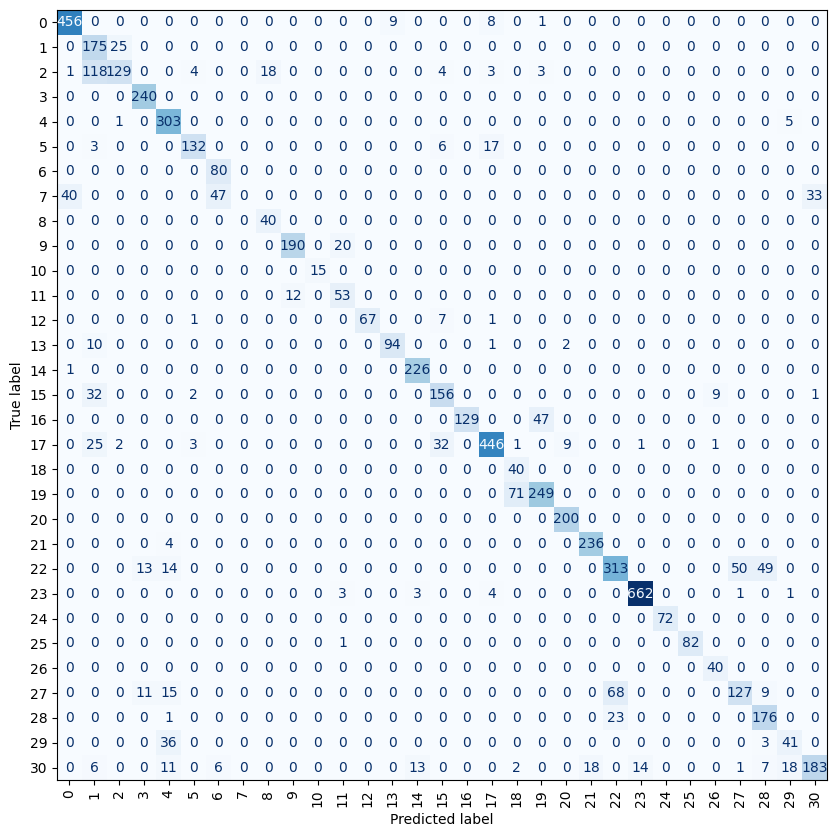

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=ax, colorbar=False)

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Model.py

In [ ]:
#model.py

import torch
import torch.nn as nn
from torchvision import models
IMAGES_SIZE=(224, 224)

class ConvNeXtTinyModel(nn.Module):
    def __init__(self, num_classes=31):
        super(ConvNeXtTinyModel, self).__init__()
        self.model = models.convnext_tiny(weights=None)
        in_features = self.model.classifier[2].in_features
        self.model.classifier[2] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

model_eval=ConvNeXtTinyModel()
model_eval.load_state_dict(torch.load("model-anna.pt", weights_only=True))

<All keys matched successfully>

In [ ]:
model_eval.to(DEVICE)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
NUM_CLASSES = 31
IMAGE_SIZE = (224, 224)

ds = load_dataset("mikkoim/aquamonitor-jyu", cache_dir="data")
hf_hub_download(repo_id="mikkoim/aquamonitor-jyu",
                filename="aquamonitor-jyu.parquet.gzip",
                repo_type="dataset",
                local_dir=".")
metadata = pd.read_parquet('aquamonitor-jyu.parquet.gzip')

classes = sorted(metadata["taxon_group"].unique())
class_map = {k: v for v, k in enumerate(classes)}
class_map_inv = {v: k for k, v in class_map.items()}

metadata["img"] = metadata["img"].str.removesuffix(".jpg")
label_dict = dict(zip(metadata["img"], metadata["taxon_group"].map(class_map)))


transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess(batch):
    images, labels = [], []
    for img, key in zip(batch["jpg"], batch["__key__"]):
        label = label_dict[key]
        img = transform(img)
        images.append(img)
        labels.append(torch.tensor(label, dtype=torch.long))
    return {"img": images, "label": labels}

ds_val = ds["validation"].with_transform(preprocess)
val_loader = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

model_eval.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader):
        images = batch["img"].to(DEVICE)
        labels = batch["label"].to(DEVICE)
        outputs = model_eval(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


y_pred = [class_map_inv[x] for x in all_preds]
y_true = [class_map_inv[x] for x in all_labels]


print(classification_report(y_true, y_pred, zero_division=0))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 50/50 [00:30<00:00,  1.67it/s]


                              precision    recall  f1-score   support

           Asellus aquaticus       0.92      0.96      0.94       474
              Caenis horaria       0.47      0.88      0.62       200
             Caenis luctuosa       0.82      0.46      0.59       280
             Ceratopogonidae       0.91      1.00      0.95       240
                Chironomidae       0.79      0.98      0.87       309
             Cloeon dipterum       0.93      0.84      0.88       158
             Cyrnus flavidus       0.60      1.00      0.75        80
            Ecnomus tenellus       0.00      0.00      0.00       120
            Ephemera vulgata       0.69      1.00      0.82        40
       Erpobdella octoculata       0.94      0.90      0.92       210
                    Gyraulus       1.00      1.00      1.00        15
        Helobdella stagnalis       0.69      0.82      0.75        65
      Heptagenia dalecarlica       1.00      0.88      0.94        76
                Hyd